In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
cd 'gdrive/Othercomputers/My MacBook Air/UNets-with-PyTorch'

/content/gdrive/Othercomputers/My MacBook Air/UNets-with-PyTorch


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from torchvision import transforms
import torch
from torch import nn
from torch.utils.data import DataLoader, random_split
from torchmetrics.classification import Dice
from tqdm import tqdm
import numpy as np

from dataset import SatelliteImageDataset
from unet import UNet
from utils import (
    one_hot_to_image,
    plot_prediction,
    compute_accuracy,
    image_to_class_index,
    class_index_to_one_hot,
    class_index_to_image,
    get_color_patches
)

In [5]:
transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ])

In [6]:
dataset = SatelliteImageDataset(
    image_dir='data/images',
    mask_dir='data/masks',
    transform=transform
)

In [7]:
train_set, test_set = random_split(dataset, [0.8, 0.2])

In [8]:
img, mask = dataset[0]

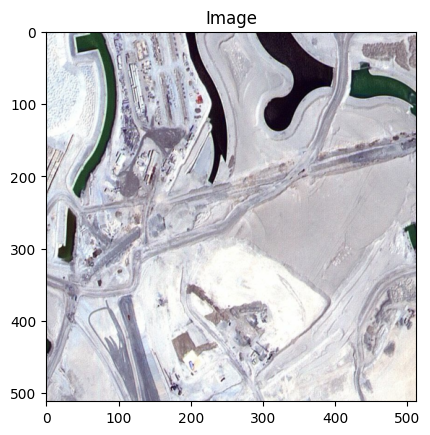

In [9]:
plt.imshow(img.permute(1, 2, 0))
plt.title('Image')
plt.show()

In [10]:
mask_labels = ['building', 'land', 'road', 'vegetation', 'water', 'unlabeled']

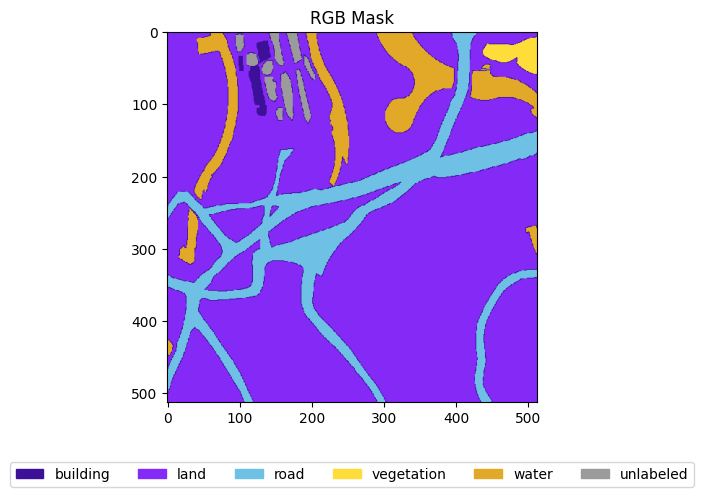

In [11]:
mask_rgb = class_index_to_image(torch.unsqueeze(mask, 0), dataset.color_map)[0]
plt.imshow(mask_rgb.permute(1, 2, 0))

patches = get_color_patches(dataset.color_map, mask_labels)
plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.25), fontsize=10, ncol=6)

plt.title('RGB Mask')
plt.show()

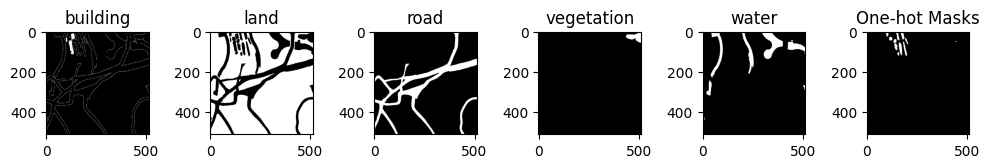

In [12]:
fig, axes = plt.subplots(1, 6, figsize=(10, 8))
mask = class_index_to_one_hot(mask, dataset.color_map)

for i in range(6):
    axes[i].imshow(mask[i], cmap='gray')
    axes[i].set_title(mask_labels[i])

plt.title('One-hot Masks')
plt.tight_layout()
plt.show()

In [13]:
train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
test_loader = DataLoader(test_set, batch_size=1)

In [14]:
LEARNING_RATE = 3e-4
EPOCHS = 50

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = UNet(in_channels=3, out_channels=6).to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = torch.nn.CrossEntropyLoss().to(device)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = Dice().to(device)

In [ ]:
# Cross Entropy training

loss_list = []
acc_list = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}:')

    model.train()
    running_loss = 0
    running_acc = 0

    for x, y in tqdm(train_loader, desc='Training', colour='#00FF00'):
        x, y = x.to(device), y.to(device) # y: (b, h, w)
        y_pred = model(x) # y_pred: (b, 6, h, w)

        loss = criterion(y_pred, y)
        running_loss += loss.item()

        # compute the accuracy of the prediction
        running_acc += compute_accuracy(y, y_pred, device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # show first image in the last batch with matplotlib
    y_imgs = class_index_to_image(y, dataset.color_map, device)
    pred_imgs = one_hot_to_image(y_pred, dataset.color_map, device)
    plot_prediction(x, y_imgs, pred_imgs, dataset.color_map, mask_labels)

    epoch_acc = running_acc / len(train_loader)
    epoch_loss = running_loss / len(train_loader)
    acc_list.append(epoch_acc)
    loss_list.append(epoch_loss)

    print(f'Accuracy: {epoch_acc:.4f} | Loss: {epoch_loss:.4f}')
    print('\n')


In [17]:
# Dice loss training

loss_list = []
acc_list = []

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}:')

    model.train()
    running_loss = 0
    running_acc = 0

    for x, y in tqdm(train_loader, desc='Training', colour='#00FF00'):
        x, y = x.to(device), y.to(device) # y: (b, h, w)
        y_pred = model(x) # y_pred: (b, 6, h, w)
        y_pred_classes = torch.argmax(y_pred, 1)

        loss = criterion(y_pred_classes, y)
        running_loss += loss.item()

        # compute the accuracy of the prediction
        running_acc += compute_accuracy(y, y_pred, device)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # show first image in the last batch with matplotlib
    y_imgs = class_index_to_image(y, dataset.color_map, device)
    pred_imgs = one_hot_to_image(y_pred, dataset.color_map, device)
    plot_prediction(x, y_imgs, pred_imgs, dataset.color_map, mask_labels)

    epoch_acc = running_acc / len(train_loader)
    epoch_loss = running_loss / len(train_loader)
    acc_list.append(epoch_acc)
    loss_list.append(epoch_loss)

    print(f'Accuracy: {epoch_acc:.4f} | Loss: {epoch_loss:.4f}')
    print('\n')


Epoch 1:


Training:   0%|          | 0/163 [00:02<?, ?it/s]


RuntimeError: element 0 of tensors does not require grad and does not have a grad_fn